# Task 2: Model Building and Training

This notebook implements comprehensive model building and evaluation for fraud detection.

## Objectives
1. **Data Preparation**: Load processed data and prepare for modeling
2. **Baseline Model**: Train Logistic Regression as interpretable baseline
3. **Ensemble Models**: Train Random Forest and XGBoost with hyperparameter tuning
4. **Cross-Validation**: Use Stratified K-Fold (k=5) for reliable performance estimation
5. **Model Comparison**: Compare all models and select the best one with justification
6. **Evaluation Metrics**: AUC-PR, F1-Score, and Confusion Matrix


In [ ]:
import sys
!{sys.executable} -m pip install matplotlib seaborn



In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle
import json
from datetime import datetime

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, f1_score,
    precision_score, recall_score, accuracy_score
)

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost not available. Install with: pip install xgboost")

warnings.filterwarnings('ignore')

# Set up paths
project_root = Path().resolve()
if project_root.name == 'notebooks':
    project_root = project_root.parent
elif (project_root / 'notebooks').exists():
    pass
else:
    current = Path().resolve()
    while current != current.parent:
        if (current / 'data').exists():
            project_root = current
            break
        current = current.parent

DATA_DIR = project_root / 'data' / 'processed'
MODELS_DIR = project_root / 'models'
OUTPUT_DIR = project_root / 'outputs' / 'eda' / 'modeling'
MODELS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Helper function to save plots (prints relative path for portability)
def save_plot(fig, filename, dpi=300, bbox_inches='tight'):
    """Save plot to output directory"""
    filepath = OUTPUT_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches=bbox_inches)
    rel = filepath.relative_to(project_root)
    print(f"Plot saved to: {rel}")

print("✓ Libraries imported successfully!")
print(f"Data directory: {DATA_DIR.relative_to(project_root)}")
print(f"Models directory: {MODELS_DIR.relative_to(project_root)}")
print(f"Output directory: {OUTPUT_DIR.relative_to(project_root)}")


✓ Libraries imported successfully!
Data directory: data\processed
Models directory: models
Output directory: outputs\eda\modeling


## 1. Data Preparation


In [4]:
# Load processed e-commerce fraud data
print("Loading E-commerce Fraud Data...")
X_train_fraud = pd.read_csv(DATA_DIR / 'fraud_train_features.csv')
y_train_fraud = pd.read_csv(DATA_DIR / 'fraud_train_target.csv')['class']
X_test_fraud = pd.read_csv(DATA_DIR / 'fraud_test_features.csv')
y_test_fraud = pd.read_csv(DATA_DIR / 'fraud_test_target.csv')['class']

print(f"\nE-commerce Data Shapes:")
print(f"Training: {X_train_fraud.shape}, Target: {y_train_fraud.shape}")
print(f"Test: {X_test_fraud.shape}, Target: {y_test_fraud.shape}")
print(f"\nTraining class distribution:")
print(y_train_fraud.value_counts())
print(f"\nTest class distribution:")
print(y_test_fraud.value_counts())


Loading E-commerce Fraud Data...

E-commerce Data Shapes:
Training: (164352, 19), Target: (164352,)
Test: (30223, 19), Target: (30223,)

Training class distribution:
class
0    109568
1     54784
Name: count, dtype: int64

Test class distribution:
class
0    27393
1     2830
Name: count, dtype: int64


In [5]:
# Load processed credit card fraud data
print("Loading Credit Card Fraud Data...")
X_train_cc = pd.read_csv(DATA_DIR / 'creditcard_train_features.csv')
y_train_cc = pd.read_csv(DATA_DIR / 'creditcard_train_target.csv')['Class']
X_test_cc = pd.read_csv(DATA_DIR / 'creditcard_test_features.csv')
y_test_cc = pd.read_csv(DATA_DIR / 'creditcard_test_target.csv')['Class']

print(f"\nCredit Card Data Shapes:")
print(f"Training: {X_train_cc.shape}, Target: {y_train_cc.shape}")
print(f"Test: {X_test_cc.shape}, Target: {y_test_cc.shape}")
print(f"\nTraining class distribution:")
print(y_train_cc.value_counts())
print(f"\nTest class distribution:")
print(y_test_cc.value_counts())


Loading Credit Card Fraud Data...

Credit Card Data Shapes:
Training: (250196, 30), Target: (250196,)
Test: (56962, 30), Target: (56962,)

Training class distribution:
Class
0    227451
1     22745
Name: count, dtype: int64

Test class distribution:
Class
0    56864
1       98
Name: count, dtype: int64


In [6]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """Comprehensive model evaluation"""
    # Calculate metrics
    auc_pr = average_precision_score(y_true, y_pred_proba)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Print metrics
    print(f"\n{'='*60}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*60}")
    print(f"AUC-PR (Average Precision): {auc_pr:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"{'='*60}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print(f"\nTrue Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")
    
    return {
        'auc_pr': auc_pr,
        'roc_auc': roc_auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, model_name, save=True):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.tight_layout()
    if save:
        save_plot(fig, f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png')
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name, save=True):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    if save:
        save_plot(fig, f'{model_name.lower().replace(" ", "_")}_roc_curve.png')
    plt.show()

def plot_pr_curve(y_true, y_pred_proba, model_name, save=True):
    """Plot Precision-Recall curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    auc_pr = average_precision_score(y_true, y_pred_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(recall, precision, label=f'{model_name} (AUC-PR = {auc_pr:.4f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    if save:
        save_plot(fig, f'{model_name.lower().replace(" ", "_")}_pr_curve.png')
    plt.show()

print("✓ Evaluation functions defined!")


✓ Evaluation functions defined!


### 3.1 E-commerce Fraud Data - Logistic Regression


Training Logistic Regression (E-commerce Data)...

Logistic Regression (E-commerce) - Performance Metrics
AUC-PR (Average Precision): 0.4516
ROC-AUC: 0.7548
F1-Score: 0.2745
Precision: 0.1708
Recall: 0.6989
Accuracy: 0.6540

Confusion Matrix:
[[17788  9605]
 [  852  1978]]

True Negatives: 17788, False Positives: 9605
False Negatives: 852, True Positives: 1978
Plot saved to: outputs\eda\modeling\logistic_regression_(e-commerce)_confusion_matrix.png


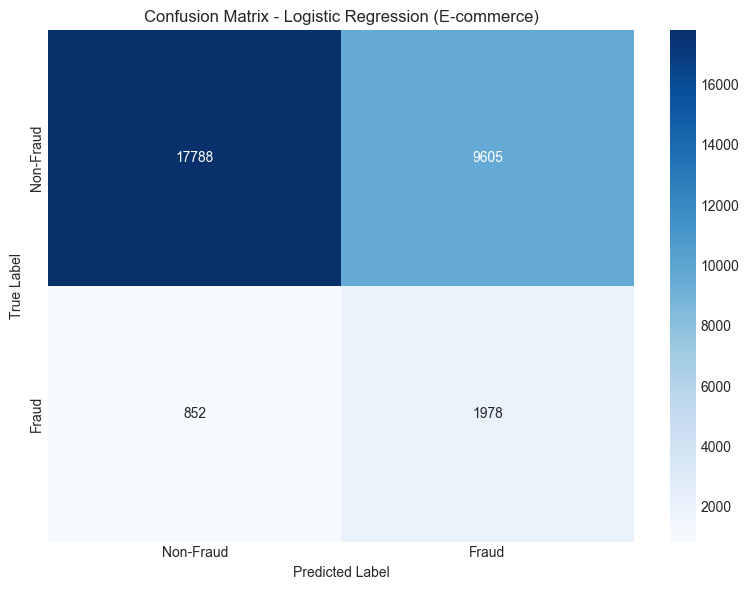

Plot saved to: outputs\eda\modeling\logistic_regression_(e-commerce)_roc_curve.png


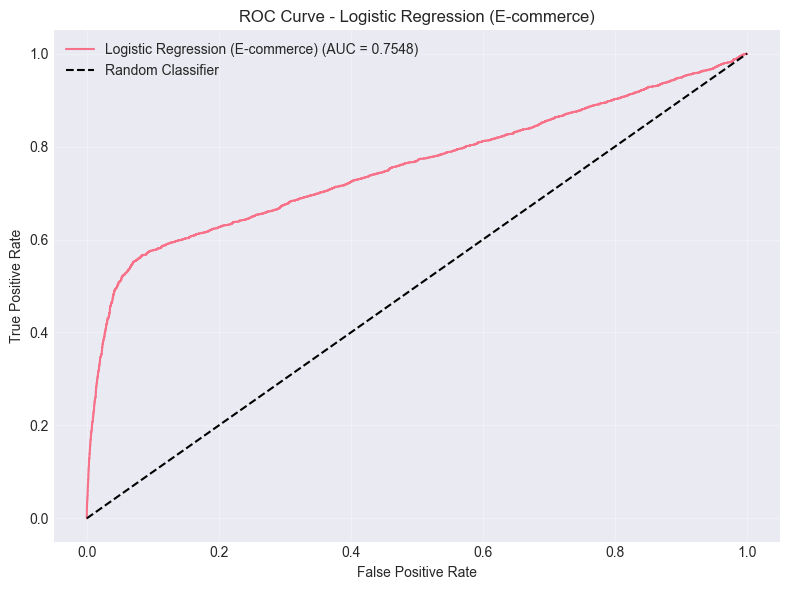

Plot saved to: outputs\eda\modeling\logistic_regression_(e-commerce)_pr_curve.png


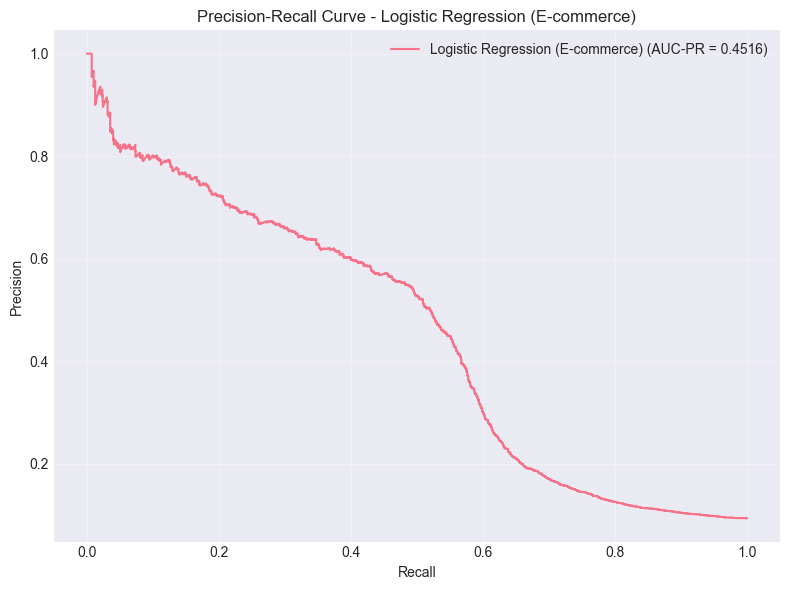

✓ Model saved to C:\Users\bamla\Downloads\Improved detection of fraud cases for e-commerce and bank transactions\models\lr_fraud_baseline.pkl


In [7]:
# Train Logistic Regression baseline for e-commerce data
print("Training Logistic Regression (E-commerce Data)...")
lr_fraud = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_fraud.fit(X_train_fraud, y_train_fraud)

# Predictions
y_pred_lr_fraud = lr_fraud.predict(X_test_fraud)
y_pred_proba_lr_fraud = lr_fraud.predict_proba(X_test_fraud)[:, 1]

# Evaluate
results_lr_fraud = evaluate_model(y_test_fraud, y_pred_lr_fraud, y_pred_proba_lr_fraud, 
                                   "Logistic Regression (E-commerce)")

# Visualizations
plot_confusion_matrix(results_lr_fraud['confusion_matrix'], "Logistic Regression (E-commerce)")
plot_roc_curve(y_test_fraud, y_pred_proba_lr_fraud, "Logistic Regression (E-commerce)")
plot_pr_curve(y_test_fraud, y_pred_proba_lr_fraud, "Logistic Regression (E-commerce)")

# Save model
with open(MODELS_DIR / 'lr_fraud_baseline.pkl', 'wb') as f:
    pickle.dump(lr_fraud, f)
print(f"✓ Model saved to {MODELS_DIR / 'lr_fraud_baseline.pkl'}")


### 3.2 Credit Card Fraud Data - Logistic Regression


Training Logistic Regression (Credit Card Data)...

Logistic Regression (Credit Card) - Performance Metrics
AUC-PR (Average Precision): 0.7236
ROC-AUC: 0.9700
F1-Score: 0.1090
Precision: 0.0580
Recall: 0.9184
Accuracy: 0.9742

Confusion Matrix:
[[55401  1463]
 [    8    90]]

True Negatives: 55401, False Positives: 1463
False Negatives: 8, True Positives: 90
Plot saved to: outputs\eda\modeling\logistic_regression_(credit_card)_confusion_matrix.png


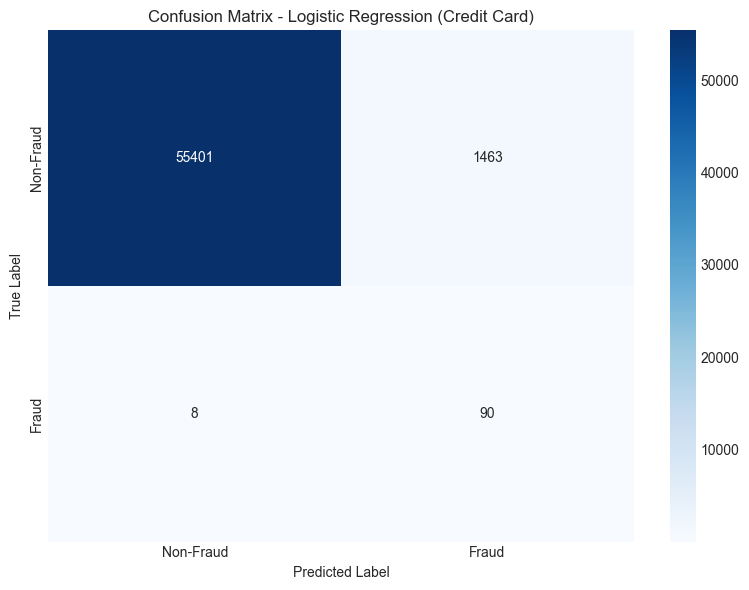

Plot saved to: outputs\eda\modeling\logistic_regression_(credit_card)_roc_curve.png


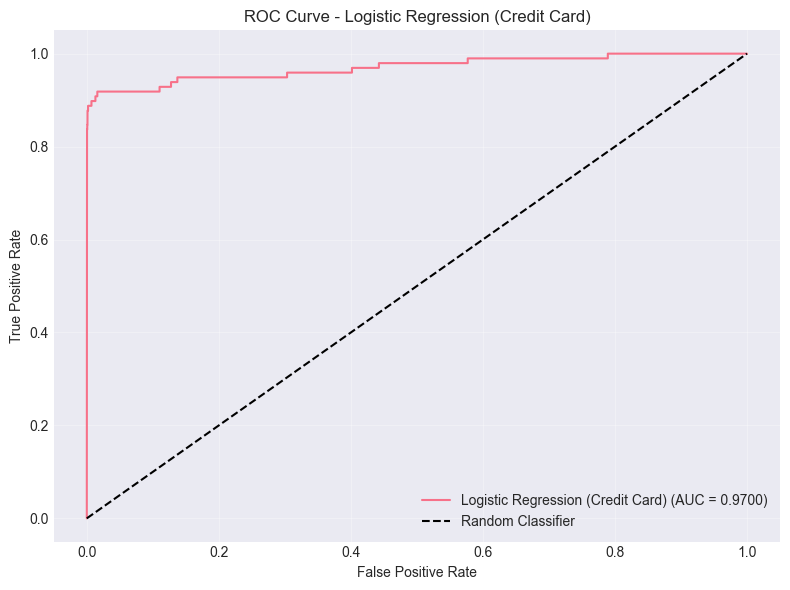

Plot saved to: outputs\eda\modeling\logistic_regression_(credit_card)_pr_curve.png


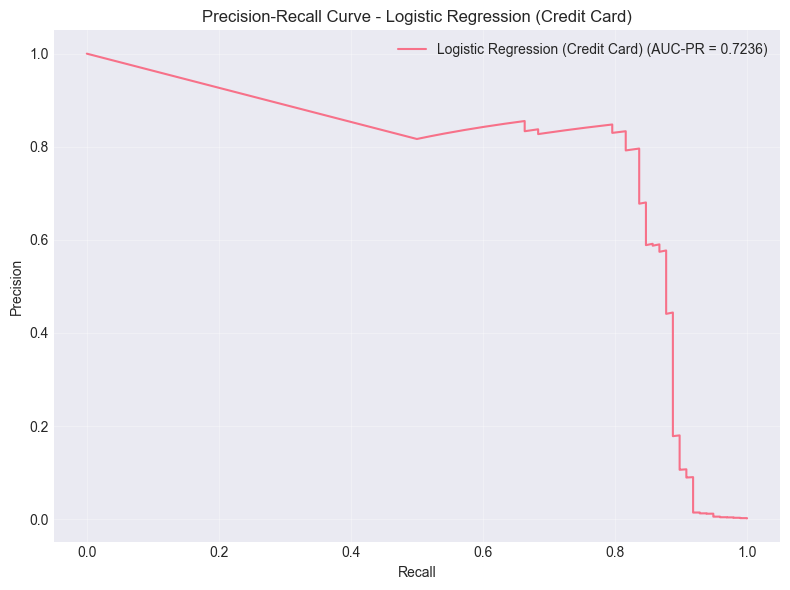

✓ Model saved to C:\Users\bamla\Downloads\Improved detection of fraud cases for e-commerce and bank transactions\models\lr_cc_baseline.pkl


In [8]:
# Train Logistic Regression baseline for credit card data
print("Training Logistic Regression (Credit Card Data)...")
lr_cc = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_cc.fit(X_train_cc, y_train_cc)

# Predictions
y_pred_lr_cc = lr_cc.predict(X_test_cc)
y_pred_proba_lr_cc = lr_cc.predict_proba(X_test_cc)[:, 1]

# Evaluate
results_lr_cc = evaluate_model(y_test_cc, y_pred_lr_cc, y_pred_proba_lr_cc, 
                               "Logistic Regression (Credit Card)")

# Visualizations
plot_confusion_matrix(results_lr_cc['confusion_matrix'], "Logistic Regression (Credit Card)")
plot_roc_curve(y_test_cc, y_pred_proba_lr_cc, "Logistic Regression (Credit Card)")
plot_pr_curve(y_test_cc, y_pred_proba_lr_cc, "Logistic Regression (Credit Card)")

# Save model
with open(MODELS_DIR / 'lr_cc_baseline.pkl', 'wb') as f:
    pickle.dump(lr_cc, f)
print(f"✓ Model saved to {MODELS_DIR / 'lr_cc_baseline.pkl'}")


## 4. Ensemble Models: Random Forest and XGBoost

We'll train Random Forest and XGBoost with hyperparameter tuning.


### 4.1 Random Forest - E-commerce Data


Hyperparameter tuning for Random Forest (E-commerce Data)...
This may take a few minutes...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1-Score: 0.9191

Random Forest (E-commerce) - Performance Metrics
AUC-PR (Average Precision): 0.6320
ROC-AUC: 0.7761
F1-Score: 0.6974
Precision: 0.9833
Recall: 0.5403
Accuracy: 0.9561

Confusion Matrix:
[[27367    26]
 [ 1301  1529]]

True Negatives: 27367, False Positives: 26
False Negatives: 1301, True Positives: 1529
Plot saved to: outputs\eda\modeling\random_forest_(e-commerce)_confusion_matrix.png


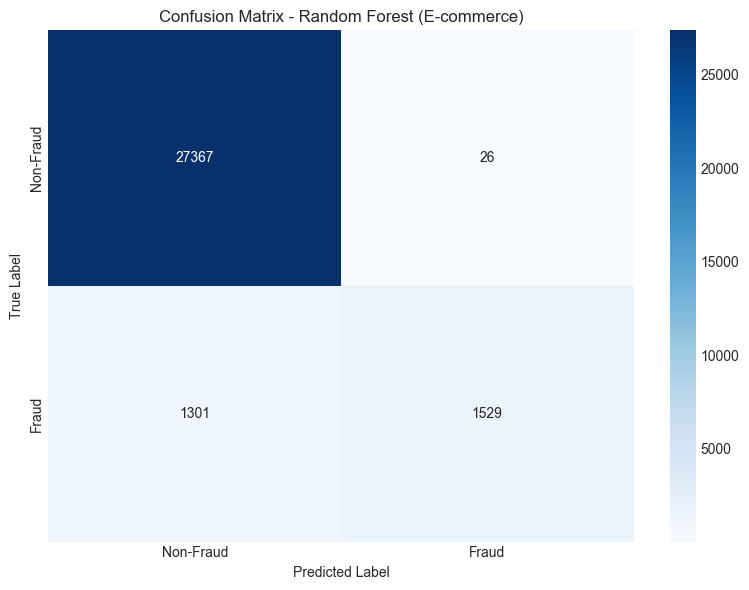

Plot saved to: outputs\eda\modeling\random_forest_(e-commerce)_roc_curve.png


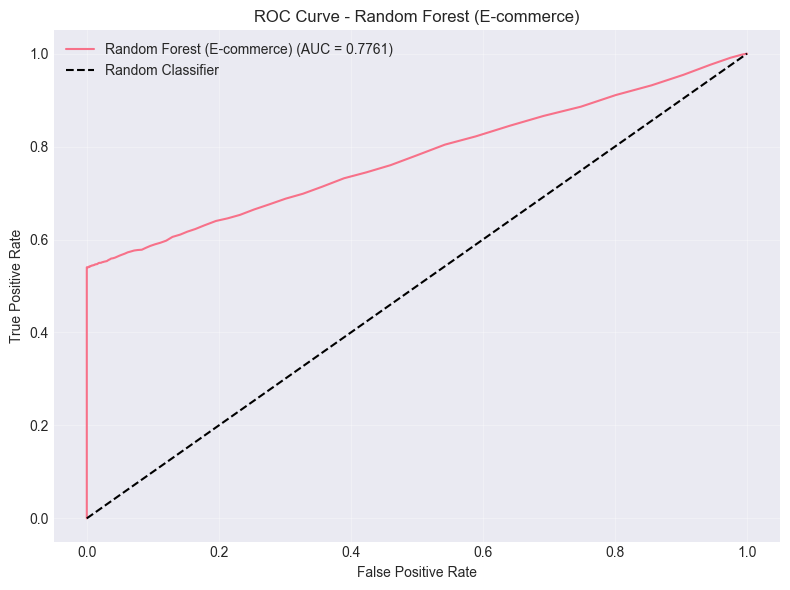

Plot saved to: outputs\eda\modeling\random_forest_(e-commerce)_pr_curve.png


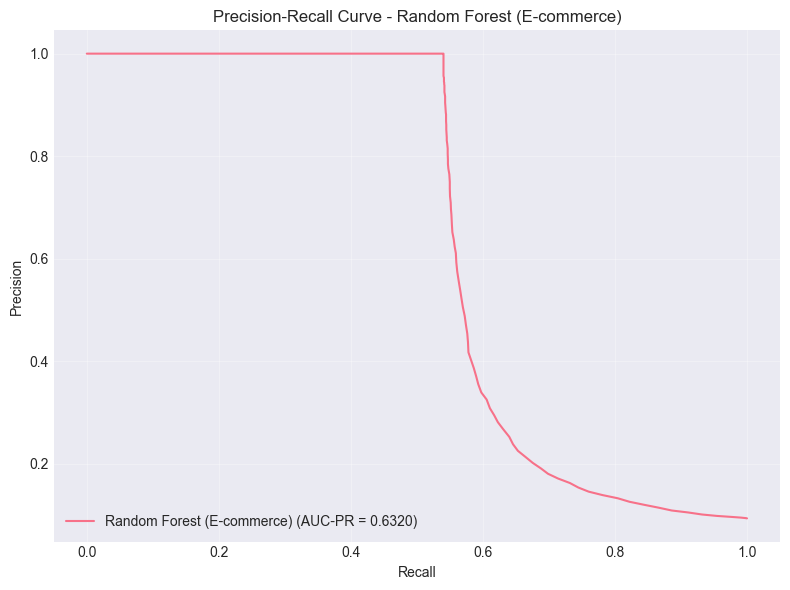

✓ Model saved to C:\Users\bamla\Downloads\Improved detection of fraud cases for e-commerce and bank transactions\models\rf_fraud_best.pkl


In [9]:
# Hyperparameter tuning for Random Forest
print("Hyperparameter tuning for Random Forest (E-commerce Data)...")
print("This may take a few minutes...")

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Grid search with cross-validation
rf_fraud = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_rf_fraud = GridSearchCV(
    rf_fraud, param_grid_rf, 
    cv=3,  # Use 3-fold for faster tuning
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf_fraud.fit(X_train_fraud, y_train_fraud)

print(f"\nBest parameters: {grid_search_rf_fraud.best_params_}")
print(f"Best CV F1-Score: {grid_search_rf_fraud.best_score_:.4f}")

# Use best model
rf_fraud_best = grid_search_rf_fraud.best_estimator_

# Predictions
y_pred_rf_fraud = rf_fraud_best.predict(X_test_fraud)
y_pred_proba_rf_fraud = rf_fraud_best.predict_proba(X_test_fraud)[:, 1]

# Evaluate
results_rf_fraud = evaluate_model(y_test_fraud, y_pred_rf_fraud, y_pred_proba_rf_fraud, 
                                   "Random Forest (E-commerce)")

# Visualizations
plot_confusion_matrix(results_rf_fraud['confusion_matrix'], "Random Forest (E-commerce)")
plot_roc_curve(y_test_fraud, y_pred_proba_rf_fraud, "Random Forest (E-commerce)")
plot_pr_curve(y_test_fraud, y_pred_proba_rf_fraud, "Random Forest (E-commerce)")

# Save model
with open(MODELS_DIR / 'rf_fraud_best.pkl', 'wb') as f:
    pickle.dump(rf_fraud_best, f)
print(f"✓ Model saved to {MODELS_DIR / 'rf_fraud_best.pkl'}")


### 4.2 XGBoost - E-commerce Data


In [10]:
# XGBoost for e-commerce data
if XGBOOST_AVAILABLE:
    print("Hyperparameter tuning for XGBoost (E-commerce Data)...")
    print("This may take a few minutes...")
    
    # Define parameter grid
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'scale_pos_weight': [1, 2]  # Handle class imbalance
    }
    
    # Grid search
    xgb_fraud = xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)
    grid_search_xgb_fraud = GridSearchCV(
        xgb_fraud, param_grid_xgb,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_xgb_fraud.fit(X_train_fraud, y_train_fraud)
    
    print(f"\nBest parameters: {grid_search_xgb_fraud.best_params_}")
    print(f"Best CV F1-Score: {grid_search_xgb_fraud.best_score_:.4f}")
    
    # Use best model
    xgb_fraud_best = grid_search_xgb_fraud.best_estimator_
    
    # Predictions
    y_pred_xgb_fraud = xgb_fraud_best.predict(X_test_fraud)
    y_pred_proba_xgb_fraud = xgb_fraud_best.predict_proba(X_test_fraud)[:, 1]
    
    # Evaluate
    results_xgb_fraud = evaluate_model(y_test_fraud, y_pred_xgb_fraud, y_pred_proba_xgb_fraud, 
                                       "XGBoost (E-commerce)")
    
    # Visualizations
    plot_confusion_matrix(results_xgb_fraud['confusion_matrix'], "XGBoost (E-commerce)")
    plot_roc_curve(y_test_fraud, y_pred_proba_xgb_fraud, "XGBoost (E-commerce)")
    plot_pr_curve(y_test_fraud, y_pred_proba_xgb_fraud, "XGBoost (E-commerce)")
    
    # Save model
    with open(MODELS_DIR / 'xgb_fraud_best.pkl', 'wb') as f:
        pickle.dump(xgb_fraud_best, f)
    print(f"✓ Model saved to {MODELS_DIR / 'xgb_fraud_best.pkl'}")
else:
    print("⚠ XGBoost not available. Skipping XGBoost model.")
    results_xgb_fraud = None


⚠ XGBoost not available. Skipping XGBoost model.


### 4.3 Random Forest - Credit Card Data


In [11]:
from sklearn.model_selection import GridSearchCV


In [ ]:
# Random Forest for credit card data
print("Hyperparameter tuning for Random Forest (Credit Card Data)...")
print("This may take a few minutes...")

grid_search_rf_cc = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1), 
    param_grid_rf,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search_rf_cc.fit(X_train_cc, y_train_cc)

print(f"\nBest parameters: {grid_search_rf_cc.best_params_}")
print(f"Best CV F1-Score: {grid_search_rf_cc.best_score_:.4f}")

rf_cc_best = grid_search_rf_cc.best_estimator_

# Predictions
y_pred_rf_cc = rf_cc_best.predict(X_test_cc)
y_pred_proba_rf_cc = rf_cc_best.predict_proba(X_test_cc)[:, 1]

# Evaluate
results_rf_cc = evaluate_model(y_test_cc, y_pred_rf_cc, y_pred_proba_rf_cc, 
                               "Random Forest (Credit Card)")

# Visualizations
plot_confusion_matrix(results_rf_cc['confusion_matrix'], "Random Forest (Credit Card)")
plot_roc_curve(y_test_cc, y_pred_proba_rf_cc, "Random Forest (Credit Card)")
plot_pr_curve(y_test_cc, y_pred_proba_rf_cc, "Random Forest (Credit Card)")

# Save model
with open(MODELS_DIR / 'rf_cc_best.pkl', 'wb') as f:
    pickle.dump(rf_cc_best, f)
print(f"✓ Model saved to {MODELS_DIR / 'rf_cc_best.pkl'}")


### 4.4 XGBoost - Credit Card Data


In [ ]:
# XGBoost for credit card data
if XGBOOST_AVAILABLE:
    print("Hyperparameter tuning for XGBoost (Credit Card Data)...")
    print("This may take a few minutes...")
    
    grid_search_xgb_cc = GridSearchCV(
        xgb.XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
        param_grid_xgb,
        cv=3,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_xgb_cc.fit(X_train_cc, y_train_cc)
    
    print(f"\nBest parameters: {grid_search_xgb_cc.best_params_}")
    print(f"Best CV F1-Score: {grid_search_xgb_cc.best_score_:.4f}")
    
    xgb_cc_best = grid_search_xgb_cc.best_estimator_
    
    # Predictions
    y_pred_xgb_cc = xgb_cc_best.predict(X_test_cc)
    y_pred_proba_xgb_cc = xgb_cc_best.predict_proba(X_test_cc)[:, 1]
    
    # Evaluate
    results_xgb_cc = evaluate_model(y_test_cc, y_pred_xgb_cc, y_pred_proba_xgb_cc, 
                                     "XGBoost (Credit Card)")
    
    # Visualizations
    plot_confusion_matrix(results_xgb_cc['confusion_matrix'], "XGBoost (Credit Card)")
    plot_roc_curve(y_test_cc, y_pred_proba_xgb_cc, "XGBoost (Credit Card)")
    plot_pr_curve(y_test_cc, y_pred_proba_xgb_cc, "XGBoost (Credit Card)")
    
    # Save model
    with open(MODELS_DIR / 'xgb_cc_best.pkl', 'wb') as f:
        pickle.dump(xgb_cc_best, f)
    print(f"✓ Model saved to {MODELS_DIR / 'xgb_cc_best.pkl'}")
else:
    print("⚠ XGBoost not available. Skipping XGBoost model.")
    results_xgb_cc = None
